In [51]:
import numpy as np
import pandas as pd
from bs4 import BeautifulSoup
import os
import glob
import re
import seaborn as sns
import matplotlib.pyplot as plt
import string
from wordcloud import WordCloud
from collections import Counter
from sklearn.feature_extraction.text import CountVectorizer
from gensim.models import Word2Vec
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
import xgboost as xgb
import imblearn.over_sampling as smote
import pickle
from sklearn.metrics import classification_report, accuracy_score


In [52]:
import nltk.corpus
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer

nltk.download('stopwords')
nltk.download('punkt')
nltk.download('wordnet')

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\kadam\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\kadam\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\kadam\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

In [53]:
directories = [
    r"data\Balance Sheets",
    r"data\Cash Flow",
    r"data\Income Statement",
    r"data\Notes",
    r"data\Others"

]


In [54]:
extracted_data = []  # Creating empty list to store text data 

for directory_path in directories:
  
    folder_name = os.path.basename(directory_path)  # Extract the folder name from the directory path
    

    html_files = glob.glob(os.path.join(directory_path, '*.html'))    # Use glob to find all HTML files in the current directory
    
   
    for file_path in html_files:   # Iterate over each HTML file
        with open(file_path, 'r', encoding='utf-8') as file:
            html_content = file.read()
        
        soup = BeautifulSoup(html_content, 'html.parser')
        
 
        text = soup.get_text()        # Extract text from the HTML
        
        extracted_data.append({
            'filename': os.path.basename(file_path),
            'text': text,
            'class': folder_name
        })

df = pd.DataFrame(extracted_data)

In [55]:
df

,filename,text,class
0,18320959_3.html,\n\n\n\n\n(7 in lacs)\n(7 in lacs)\n\n_1_\nSta...,Balance Sheets
1,18391125_2.html,\n\n\n\n\nConsolidated\nStandalone\n\nParticul...,Balance Sheets
2,18442877_5.html,\n\n\n\n\nStandalone\nConsolidated\n\n\nAudite...,Balance Sheets
3,18445487_2.html,\n\n\n\nGUJARAT NARMADA VALLEY FERTILIZERS & C...,Balance Sheets
4,18445494_3.html,\n\n\n\n\n\nStandalone\nConsolidated\n\n\n\n\n...,Balance Sheets
...,...,...,...
2520,18964858_6.html,"\n\n\n\n1.\nSinghi & Co.,\n2.\nChatterjee & Co...",Others
2521,18964858_7.html,\n\n\n\nSinghi & Co.\nChatterjee &Co.\nV.K. Dh...,Others
2522,18964858_8.html,"\n\n\n\nr* • • *“•""\n1\n1\ni\n•\n•\n1\n1\n1\nS...",Others
2523,19213523_4.html,\n\n\n\nParticulars\nQuarter ended\nYear ended...,Others


In [56]:
# creating function to convert text to lower case

def convert_lower(text):
    return text.lower()


# creating a function to remove punctuation
def remove_punctuation(text):
    return text.translate(str.maketrans(' ', ' ', string.punctuation))


# remove '\n' from the text
def remove_new_line(text):
    return text.replace('\n', ' ')


#remove URL and '@' from the text
def remove_url(text):
    return re.sub(r"(@\[A-Za-z0-9]+)|([^0-9A-Za-z \t])|(\w+:\/\/\S+)|^rt|http.+?", "", text)


# remove numbers from the text
def remove_numbers(text):
    return re.sub(r'\d+', ' ', text)


# convert all the above functions to one function
def preprocess(text):
    text = convert_lower(text)
    text = remove_punctuation(text)
    text = remove_new_line(text)
    text = remove_url(text)
    text = remove_numbers(text)
    return text

In [57]:
# Apply the preprocess function to the 'text' column
df['text'] = df['text'].apply(preprocess)


df

,filename,text,class
0,18320959_3.html,in lacs in lacs standalone consoli...,Balance Sheets
1,18391125_2.html,consolidated standalone particulars as a...,Balance Sheets
2,18442877_5.html,standalone consolidated audited audited...,Balance Sheets
3,18445487_2.html,gujarat narmada valley fertilizers chemic...,Balance Sheets
4,18445494_3.html,standalone consolidated as at as a...,Balance Sheets
...,...,...,...
2520,18964858_6.html,singhi co chatterjee co vk dhingra...,Others
2521,18964858_7.html,singhi co chatterjee co vk dhingra co ak...,Others
2522,18964858_8.html,r i steel authority of indi...,Others
2523,19213523_4.html,particulars quarter ended year ended marc...,Others


In [58]:
 # Function to lemmatize text
def lemmatize_text(text):  
    lemmatizer = WordNetLemmatizer()
    tokenized_string = word_tokenize(text)
    lemmatized_words = [lemmatizer.lemmatize(word) for word in tokenized_string]
    return ' '.join(lemmatized_words)


# Function to remove duplicate words
def remove_duplicates(text):   
    words = text.split()
    seen = set()
    unique_words = [word for word in words if not (word in seen or seen.add(word))]
    return ' '.join(unique_words)


# Applying the functions to the text column
df['text'] = df['text'].apply(lemmatize_text)
df['text'] = df['text'].apply(remove_duplicates)


df

,filename,text,class
0,18320959_3.html,in lac standalone consolidated sr no particula...,Balance Sheets
1,18391125_2.html,consolidated standalone particular a at mar as...,Balance Sheets
2,18442877_5.html,standalone consolidated audited particular a a...,Balance Sheets
3,18445487_2.html,gujarat narmada valley fertilizer chemical lim...,Balance Sheets
4,18445494_3.html,standalone consolidated a at particular equity...,Balance Sheets
...,...,...,...
2520,18964858_6.html,singhi co chatterjee vk dhingra aksabat charte...,Others
2521,18964858_7.html,singhi co chatterjee vk dhingra aksabat charte...,Others
2522,18964858_8.html,r i steel authority of india limitedcin l dl g...,Others
2523,19213523_4.html,particular quarter ended year march audited re...,Others


In [59]:

# extracting all stopwords for english language and adding extra stopwords
stop = list(stopwords.words('english'))
additional_stopwords = ['sub', 'total','lac', 'rs', 'rupees', 'audited', 'jan', 'feb', 'mar', 'may', 'jun','jul',
                        'aug', 'sep', 'oct', 'nov', 'dec','January', 'February', 'March', ' lac', 'lacs',
                        'April', 'May', 'June', 'July', 'August', 'September', 'October',
                        'November', 'December', 'january', 'february', 'march', 'april',
                        'may', 'june', 'july', 'august', 'september', 'october', 'november',
                        'december','INR', 'inr', 'Crores', 'crores', 'quarter', 'ended',
                        'year', 'total', 'i', 'ii', 'iii', 'iv', 'v', 'vi', 'vii', 'viii', 'ix',
                        'a', 'b', 'c', 'd', 'e', 'f', 'g', 'h', 'i', 'j', 'k', 'l', 'm', 'n', 'o', 'p',
                        'q', 'r', 's', 't', 'u', 'v', 'w', 'x', 'y', 'z']
total_stopwords = stop + additional_stopwords

In [60]:
# Define a function to remove stopwords
def remove_stopwords(text):
  # Split the text into words
  words = text.split()

  # Remove stopwords
  filtered_words = [word for word in words if word not in total_stopwords]

  # Join the filtered words back into a string
  return " ".join(filtered_words).strip()

# Apply the remove_stopwords function to the 'text' column
df['text'] = df['text'].apply(remove_stopwords)

df


,filename,text,class
0,18320959_3.html,standalone consolidated sr particular stmarch ...,Balance Sheets
1,18391125_2.html,consolidated standalone particular asset noncu...,Balance Sheets
2,18442877_5.html,standalone consolidated particular equity liab...,Balance Sheets
3,18445487_2.html,gujarat narmada valley fertilizer chemical lim...,Balance Sheets
4,18445494_3.html,standalone consolidated particular equity liab...,Balance Sheets
...,...,...,...
2520,18964858_6.html,singhi co chatterjee vk dhingra aksabat charte...,Others
2521,18964858_7.html,singhi co chatterjee vk dhingra aksabat charte...,Others
2522,18964858_8.html,steel authority india limitedcin dl go registe...,Others
2523,19213523_4.html,particular refer note reviewed income fromoper...,Others


# DATA WRANGLING & VISUALISATION

c:\Users\kadam\anaconda3\envs\streamlitenv\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


Text(0.5, 1.0, 'length distribution')

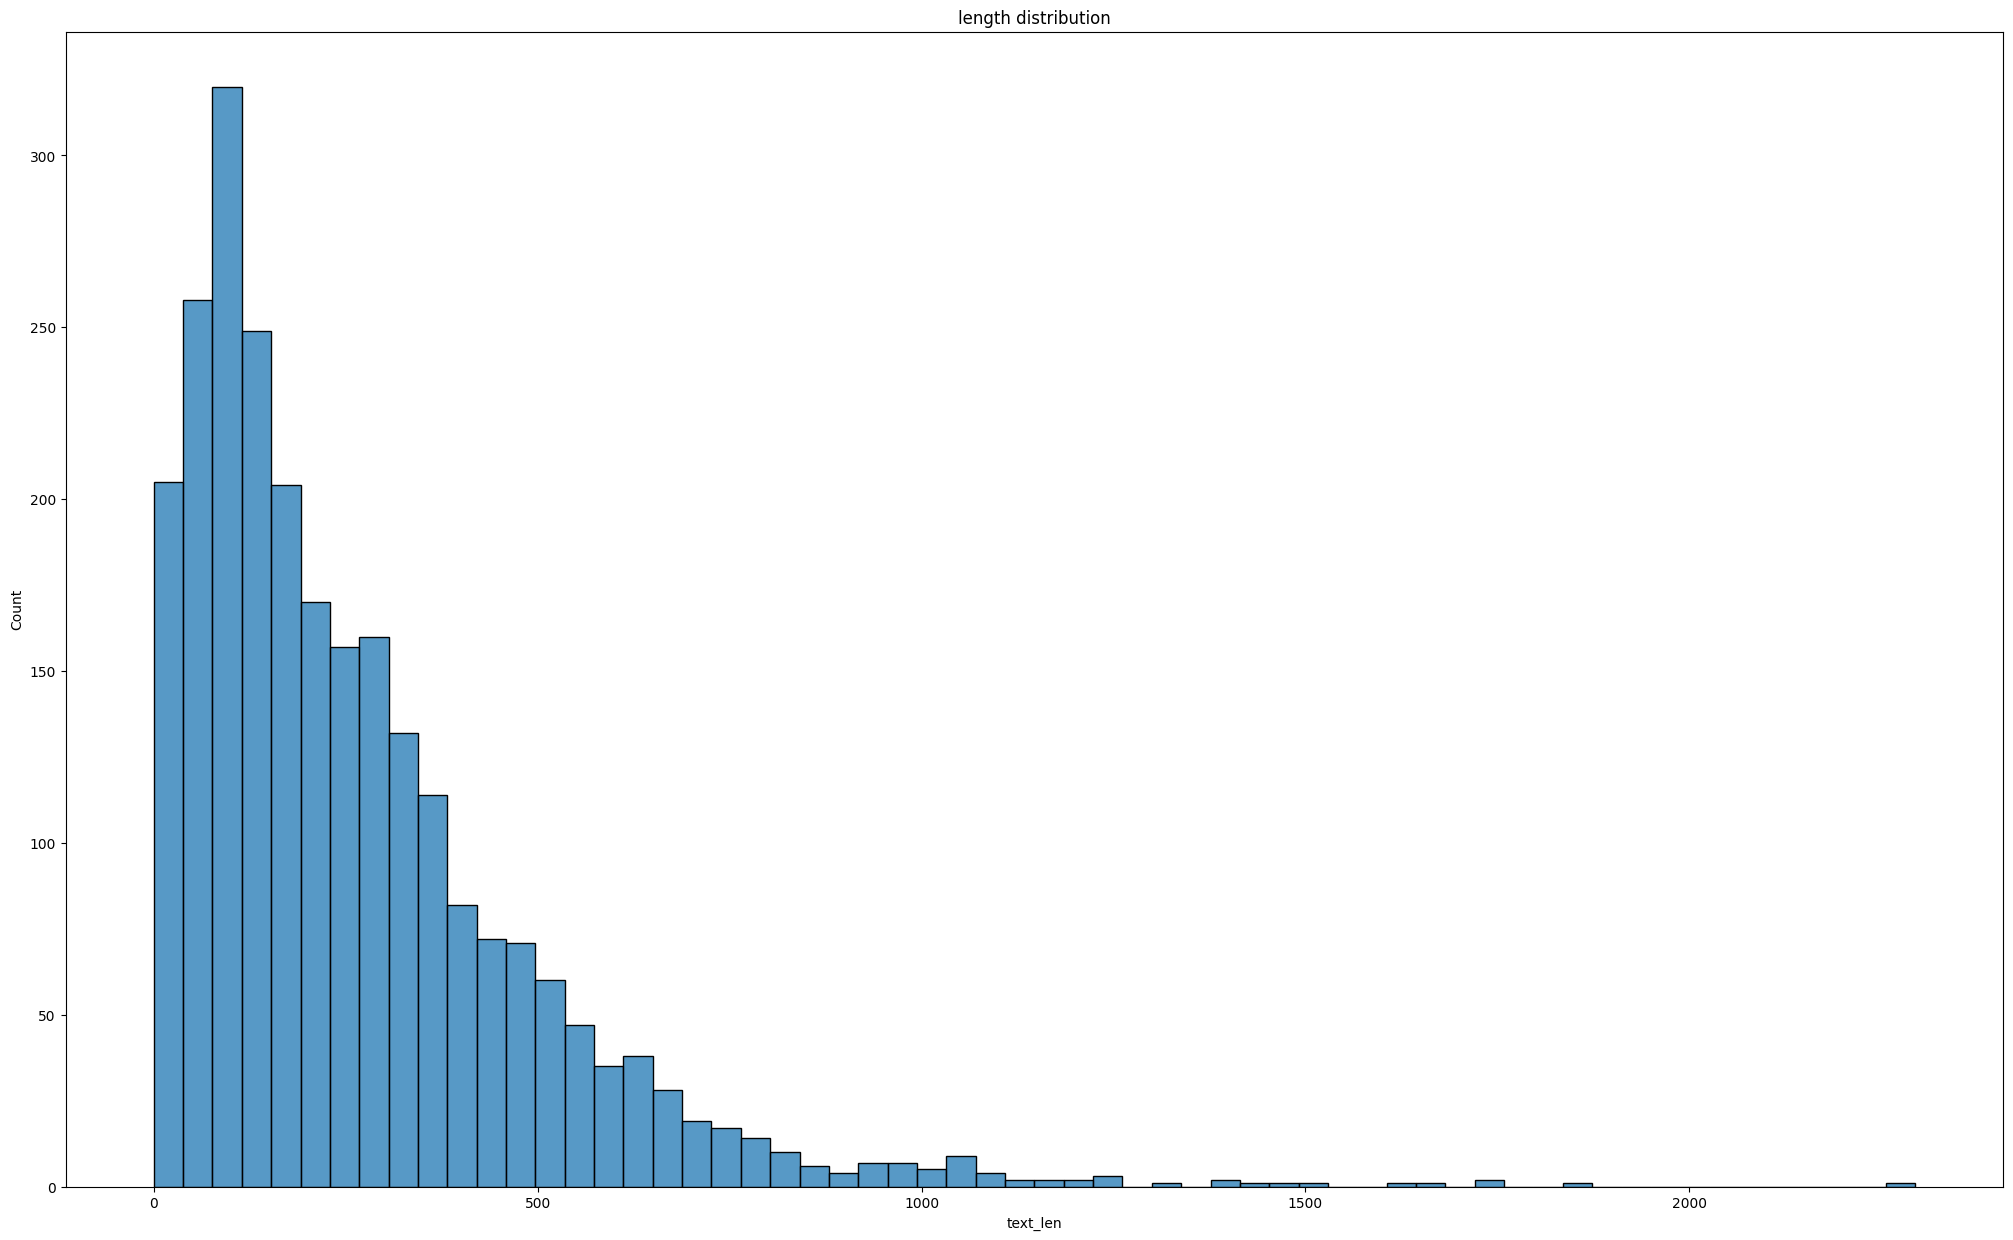

In [61]:

df['text_len'] = df['text'].str.len()

plt.figure(figsize=(25, 15))
sns.histplot(df['text_len']).set_title('length distribution')

c:\Users\kadam\anaconda3\envs\streamlitenv\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
c:\Users\kadam\anaconda3\envs\streamlitenv\Lib\site-packages\seaborn\_oldcore.py:1075: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
c:\Users\kadam\anaconda3\envs\streamlitenv\Lib\site-packages\seaborn\_oldcore.py:1075: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
c:\Users\kadam\anaconda3\envs\streamlitenv\Lib\site-pa

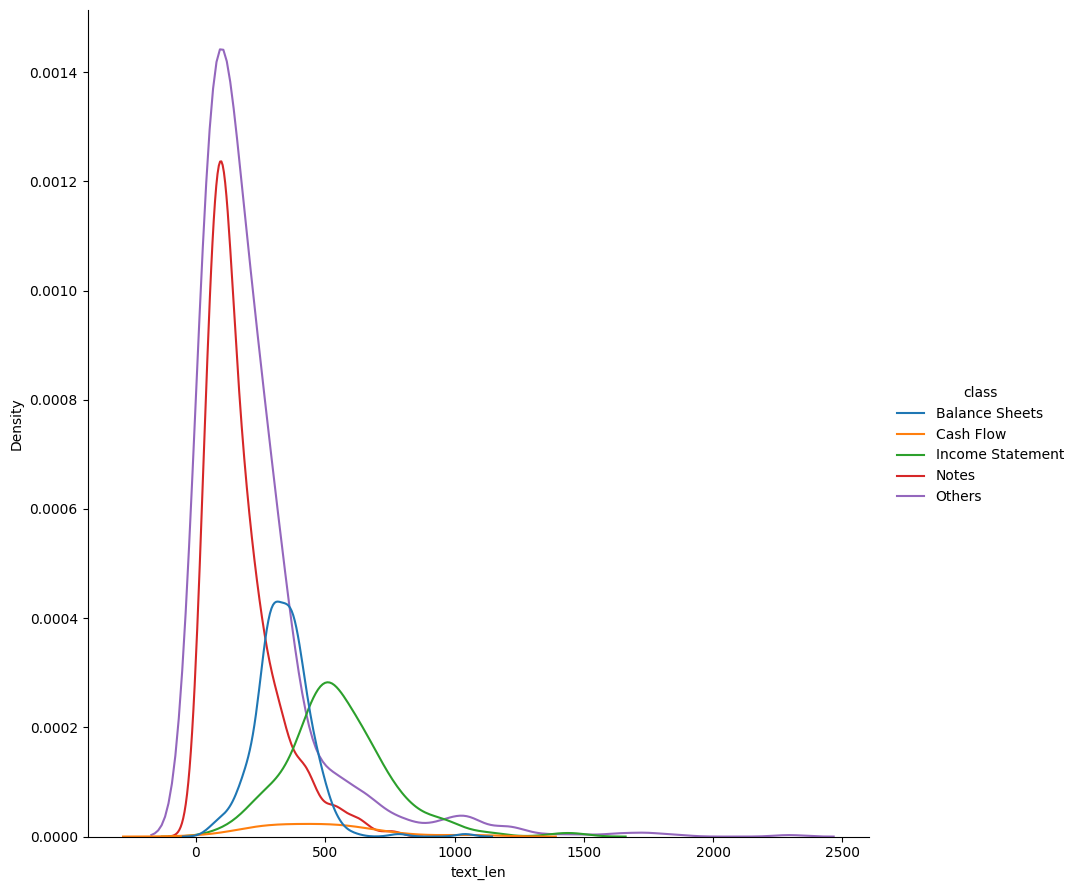

In [62]:

#Dist plot for each category
sns.displot(df, x="text_len", hue="class", kind="kde",height=9,aspect =1 )

Text(0.5, 1.0, 'Count per Category')

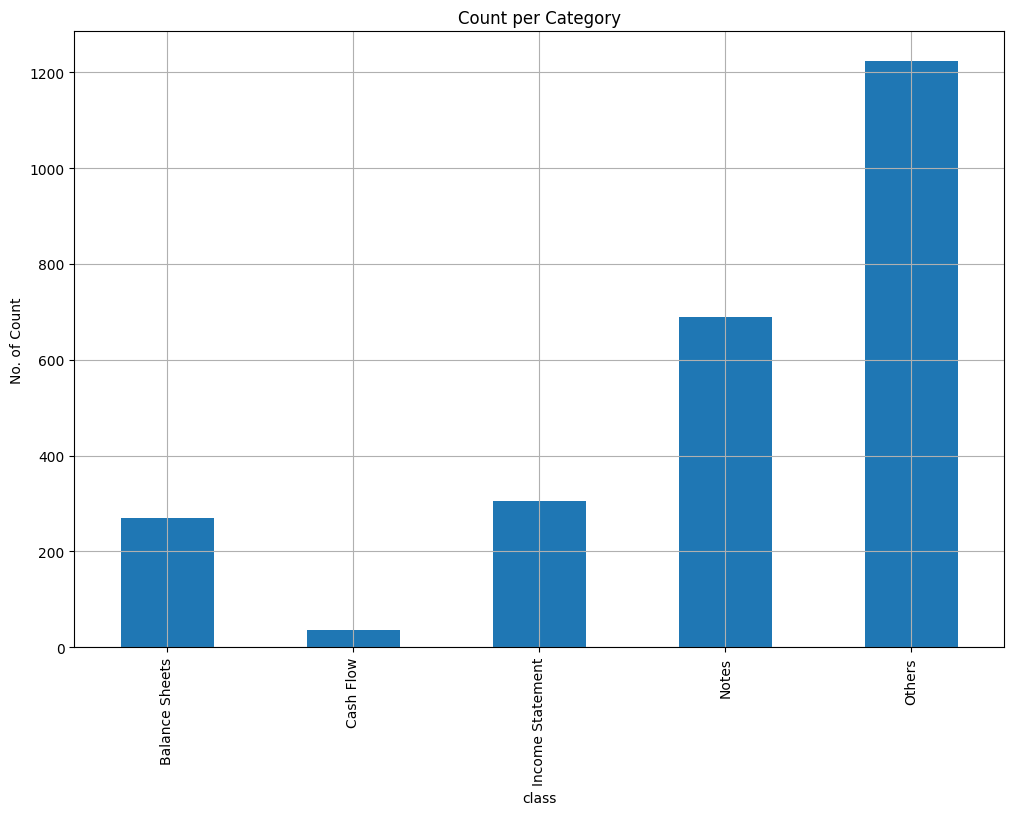

In [63]:
class_count =df.groupby(['class'],)['class'].count()
plt.figure(figsize=(12,8))
class_count.plot(kind ='bar', grid =True)
plt.ylabel("No. of Count")
plt.title("Count per Category")
     

In [64]:
def get_top_n_words(n_top_words, count_vectorizer, text_data):

    # encoding the document using countvectorizer object
    vectorized_content = count_vectorizer.fit_transform(text_data.values)
    vectorized_total = np.sum(vectorized_content, axis=0)

    # extracting specifics for words
    word_indices = np.flip(np.argsort(vectorized_total)[0,:], 1)
    word_values = np.flip(np.sort(vectorized_total)[0,:],1)

    # creating a vector matrix for words
    word_vectors = np.zeros((n_top_words, vectorized_content.shape[1]))
    for i in range(n_top_words):
        word_vectors[i,word_indices[0,i]] = 1

    # display Vector matrix
    print(word_vectors)

    # collect the words
    words = [word[0].encode('ascii').decode('utf-8') for
             word in count_vectorizer.inverse_transform(word_vectors)]

    return (words, word_values[0,:n_top_words].tolist()[0])
     

### CountVectorizer is efficient for capturing word frequencies.

[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]


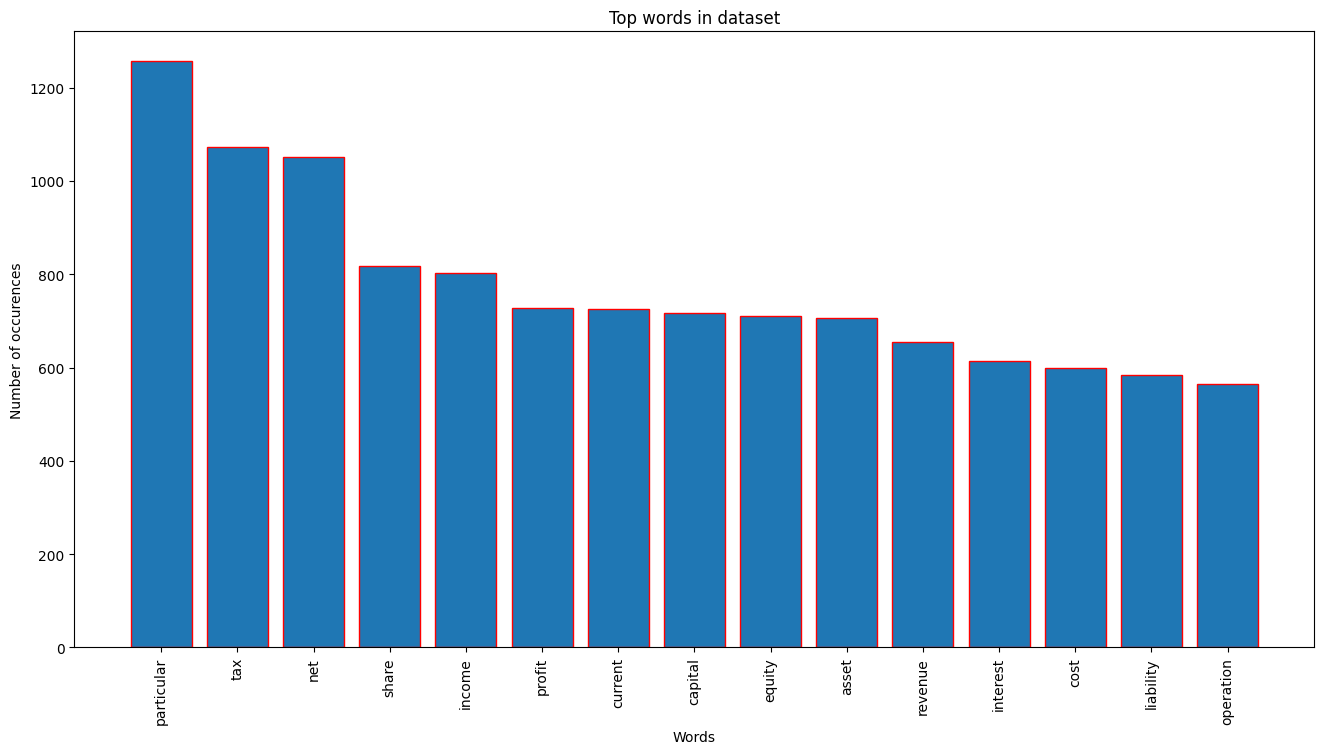

In [65]:
# creating vectorizer object
vectorizer = CountVectorizer(stop_words=total_stopwords)

# calling the function to get words and their counts
words, word_values = get_top_n_words(n_top_words=15,
                                     count_vectorizer=vectorizer,
                                     text_data=df['text'])

# display top 25 words using bar plot
fig, ax = plt.subplots(figsize=(16,8))
ax.bar(range(len(words)), word_values, edgecolor='red')
ax.set_xticks(range(len(words)))
ax.set_xticklabels(words, rotation='vertical')
ax.set_title('Top words in dataset')
ax.set_xlabel('Words')
ax.set_ylabel('Number of occurences')
plt.show()

In [66]:
def create_wordcloud(words):
    wordcloud = WordCloud(width=800, height=500, random_state=42, max_font_size=110).generate(words)
    plt.figure(figsize=(12, 8))
    plt.imshow(wordcloud, interpolation="bilinear")
    plt.axis('off')
    plt.show()
     

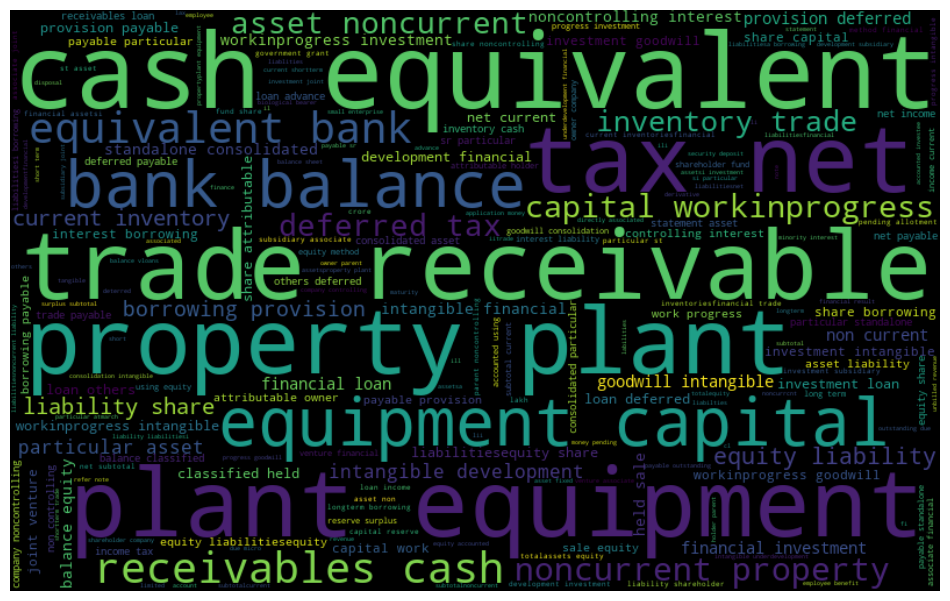

In [67]:
# Balance Sheets
subset=df[df['class']=="Balance Sheets"]
text=subset['text'].values
words =" ".join(text)
create_wordcloud(words)
     

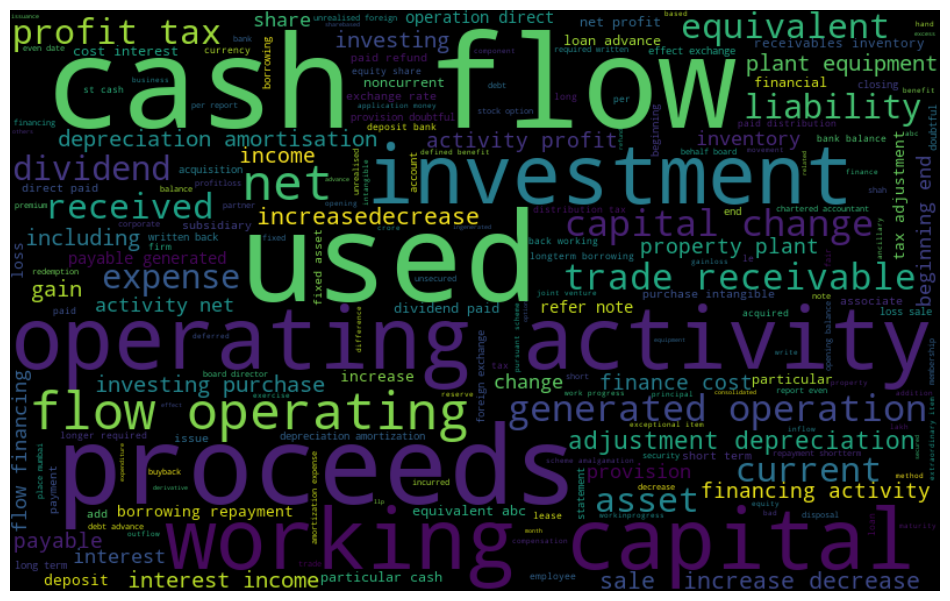

In [68]:
# Cash Flow
subset=df[df['class']=="Cash Flow"]
text=subset['text'].values
words =" ".join(text)
create_wordcloud(words)

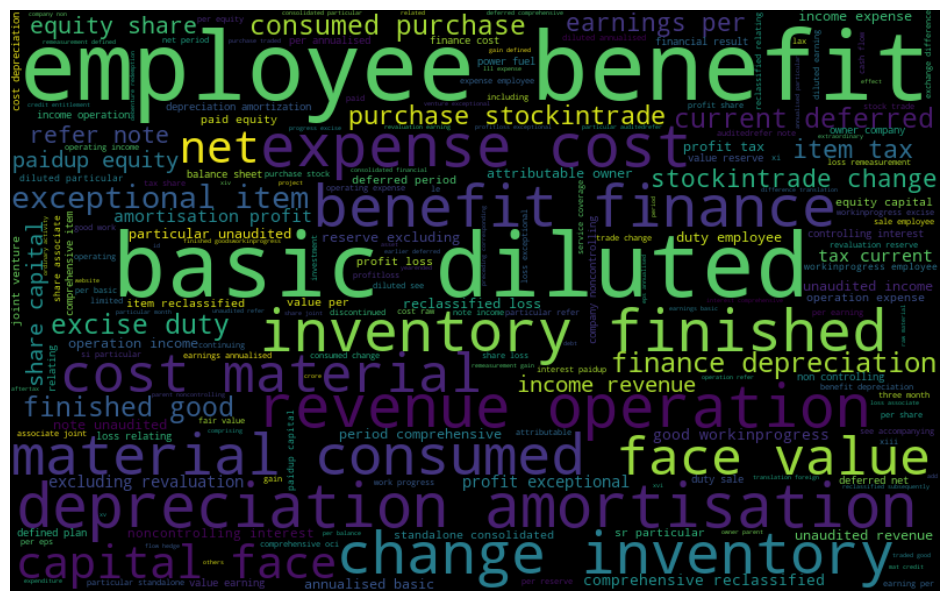

In [69]:
# Income Statements
subset=df[df['class']=="Income Statement"]
text=subset['text'].values
words =" ".join(text)
create_wordcloud(words)

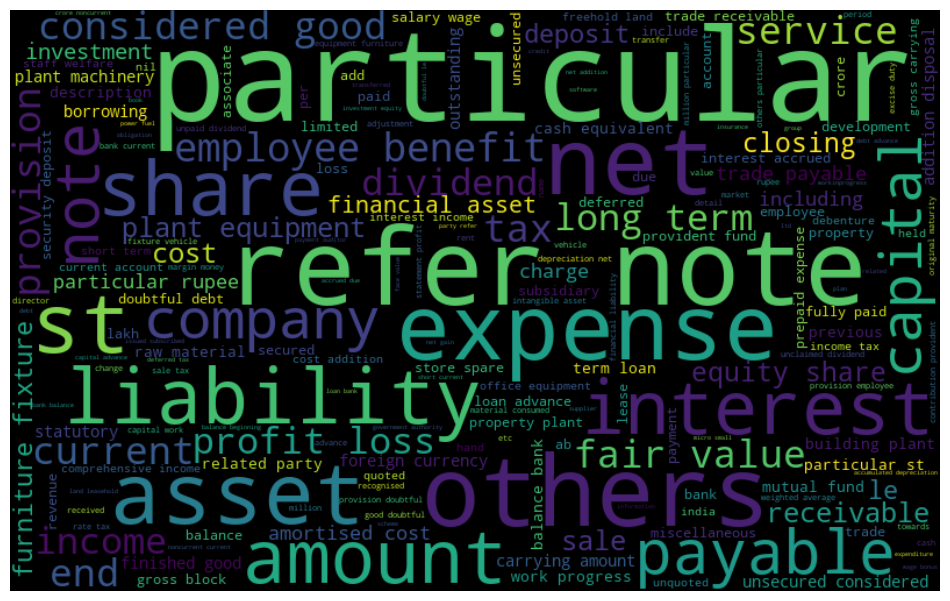

In [70]:
# Notes
subset=df[df['class']=="Notes"]
text=subset['text'].values
words =" ".join(text)
create_wordcloud(words)

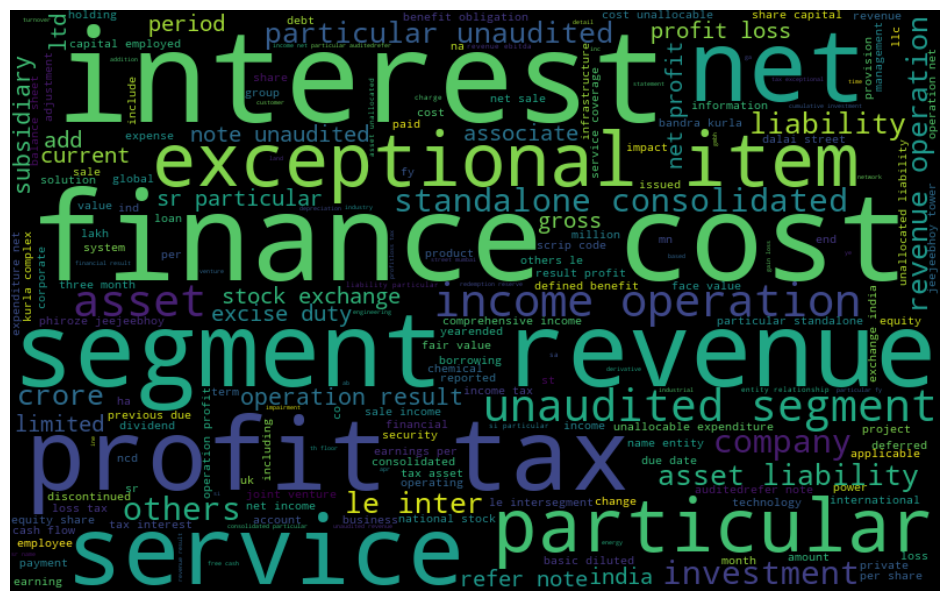

In [71]:
# Others
subset=df[df['class']=="Others"]
text=subset['text'].values
words =" ".join(text)
create_wordcloud(words)

In [72]:
df

,filename,text,class,text_len
0,18320959_3.html,standalone consolidated sr particular stmarch ...,Balance Sheets,313
1,18391125_2.html,consolidated standalone particular asset noncu...,Balance Sheets,354
2,18442877_5.html,standalone consolidated particular equity liab...,Balance Sheets,403
3,18445487_2.html,gujarat narmada valley fertilizer chemical lim...,Balance Sheets,440
4,18445494_3.html,standalone consolidated particular equity liab...,Balance Sheets,354
...,...,...,...,...
2520,18964858_6.html,singhi co chatterjee vk dhingra aksabat charte...,Others,166
2521,18964858_7.html,singhi co chatterjee vk dhingra aksabat charte...,Others,166
2522,18964858_8.html,steel authority india limitedcin dl go registe...,Others,519
2523,19213523_4.html,particular refer note reviewed income fromoper...,Others,147


In [73]:
# creating a countvectorizer object
vectorizer = CountVectorizer(stop_words = total_stopwords)

# encode the textual content
vectored_text = vectorizer.fit_transform(df['text'])

In [74]:
features = vectored_text.toarray()
print(features)

[[0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 ...
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]]


In [75]:
df['class'].value_counts()

class
Others              1224
Notes                690
Income Statement     305
Balance Sheets       270
Cash Flow             36
Name: count, dtype: int64

In [76]:

oversample = smote.SMOTE(k_neighbors=5)

X = features
y = df['class']

X, y = oversample.fit_resample(X, y)    # Apply SMOTE to oversample the minority class

y.value_counts()   # Print the value counts for target variable

class
Balance Sheets      1224
Cash Flow           1224
Income Statement    1224
Notes               1224
Others              1224
Name: count, dtype: int64

In [77]:
# Splitting the data into training and testing sets after applyig smote 

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

In [78]:

le = LabelEncoder()

# Encode the labels in y_train and y_test 
y_train = le.fit_transform(y_train)
y_test = le.transform(y_test)

In [79]:

models = {
        "Logistic Regression": LogisticRegression(),
        "Decision Tree": DecisionTreeClassifier(),
        "Random Forest": RandomForestClassifier(),
        "Gradient Boosting" : GradientBoostingClassifier(),
        "XGBoost" : xgb.XGBClassifier(),
        "Support Vector Machine": SVC(),
        "K-Nearest Neighbors": KNeighborsClassifier()
    }

for model_name, model in models.items():
    # Train the model
    model.fit(X_train, y_train)

    # Make predictions on test data
    y_pred = model.predict(X_test)

    # Evaluate model performance
    accuracy = accuracy_score(y_test, y_pred)
    report = classification_report(y_test, y_pred)

    # Print results for current model
    print(f"** Results for {model_name} Model **")
    print(f"Accuracy: {accuracy:.4f}")
    print(f"Classification Report:\n{report}")
    print("-"*80)

# Select view as Scrollable element to view all the outputs

** Results for Logistic Regression Model **
Accuracy: 0.9616
Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       249
           1       0.99      1.00      0.99       275
           2       0.99      0.98      0.99       228
           3       0.89      0.96      0.92       250
           4       0.95      0.86      0.90       222

    accuracy                           0.96      1224
   macro avg       0.96      0.96      0.96      1224
weighted avg       0.96      0.96      0.96      1224

--------------------------------------------------------------------------------
** Results for Decision Tree Model **
Accuracy: 0.9338
Classification Report:
              precision    recall  f1-score   support

           0       0.98      0.98      0.98       249
           1       0.98      1.00      0.99       275
           2       0.97      0.98      0.97       228
           3       0.84      0.90      0.87       2

In [80]:
# Fine-tune the model using GridSearchCV

param_grid = {
    'n_estimators': [100, 200, 300],
    'max_depth': [3, 5, 8],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 5],
    'max_features': ['sqrt', 'log2']
}

# Define the Randome Forest classifier
rf_model = RandomForestClassifier()

# Create the GridSearchCV object
grid_search = GridSearchCV(estimator=rf_model, param_grid=param_grid, scoring='accuracy', cv=5, error_score= 'raise')

# Fit the grid search to the training data
grid_search.fit(X_train, y_train)

# Get the best model with the highest accuracy score
best_model = grid_search.best_estimator_
best_score = grid_search.best_score_

# Make predictions on the test data using the best model
y_pred = best_model.predict(X_test)

# Evaluate the model performance
accuracy = accuracy_score(y_test, y_pred)
print("Accuracy Score:", accuracy)
print("Classification Report:\n", classification_report(y_test, y_pred))

# Print the best score and its corresponding parameters
print("\nBest Score:", best_score)
print("Best Parameters:", grid_search.best_params_)


Accuracy Score: 0.9191176470588235
Classification Report:
               precision    recall  f1-score   support

           0       0.98      0.97      0.98       249
           1       1.00      0.95      0.97       275
           2       0.96      0.95      0.96       228
           3       0.79      0.90      0.84       250
           4       0.88      0.82      0.85       222

    accuracy                           0.92      1224
   macro avg       0.92      0.92      0.92      1224
weighted avg       0.92      0.92      0.92      1224


Best Score: 0.9174870234099769
Best Parameters: {'max_depth': 8, 'max_features': 'log2', 'min_samples_leaf': 1, 'min_samples_split': 5, 'n_estimators': 300}


In [81]:

from sklearn.model_selection import KFold

# Step 4: Perform custom cross-validation using KFold
kf = KFold(n_splits=5, shuffle=True, random_state=42)
custom_cv_scores = []

for train_index, test_index in kf.split(X):
    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = y[train_index], y[test_index]
    rf_model.fit(X_train, y_train)
    score = rf_model.score(X_test, y_test)
    custom_cv_scores.append(score)

# Convert to a numpy array for easier manipulation
custom_cv_scores = np.array(custom_cv_scores)

# Print the custom cross-validation scores
print("Custom cross-validation scores: ", custom_cv_scores)
print("Mean custom cross-validation score: ", np.mean(custom_cv_scores))

Custom cross-validation scores:  [0.96895425 0.9501634  0.95915033 0.9501634  0.9624183 ]
Mean custom cross-validation score:  0.9581699346405228


In [82]:

# Saving the model to a pickle file
with open('finacplus_rfmodel.pkl', 'wb') as f: 
    pickle.dump(rf_model, f)


## LDA model (Latent Dirichlet Allocation)

Latent Dirichlet Allocation (LDA) algorithm is an unsupervised learning algorithm that attempts to describe a set of observations as a mixture of distinct categories. LDA is most commonly used to discover a user-specified number of topics shared by documents within a text corpus.


An advantage of the LDA technique is that one does not have to know in advance what the topics will look like. By tuning the LDA parameters to fit different dataset shapes, one can explore topic formation and resulting document clusters.

In [83]:
from sklearn.decomposition import LatentDirichletAllocation

In [84]:
#we are defining the number of topics we want to segreggate into
grid_params = {'n_components' : [5]}

# creating LDA model object
lda = LatentDirichletAllocation(random_state = 42)

# fitting the model
lda_model = GridSearchCV(lda, param_grid = grid_params)
lda_model.fit(X)

# best LDA model
best_lda_model = lda_model.best_estimator_
print("Best log likelihood Score for the LDA model",lda_model.best_score_)
print("LDA model Perplexity on train data", best_lda_model.perplexity(X))
     

Best log likelihood Score for the LDA model -268869.638392671
LDA model Perplexity on train data 382.39277638749763


While the log-likelihood score suggests a good fit, the high perplexity indicates potential shortcomings in topic representation. This could mean : The number of topics chosen might not be optimal. The model struggles to capture the semantic relationships within topics

# Latent Semantic Analysis (LSA):

Latent Semantic Analysis (LSA) is a method that allows us to extract topics from documents by converting their text into word-topic and document-topic matrices

In [87]:

from sklearn.decomposition import TruncatedSVD

# SVD represent documents and terms in vectors
svd_model = TruncatedSVD(n_components=5, algorithm='randomized', n_iter=100, random_state=42)

svd_model.fit(X)

TruncatedSVD(n_components=5, n_iter=100, random_state=23)

In [88]:

terms = vectorizer.get_feature_names_out()

for i, comp in enumerate(svd_model.components_):
    terms_comp = zip(terms, comp)
    sorted_terms = sorted(terms_comp, key= lambda x:x[1], reverse=True)[:40]
    print(" ")
    print("Topic "+str(i)+": ")
    print(" ")
    for t in sorted_terms:
        print(t[0])

 
Topic 0: 
 
tax
net
capital
share
current
particular
inventory
equity
income
profit
cash
deferred
asset
operation
depreciation
trade
cost
payable
receivables
investment
change
finance
loss
interest
provision
expense
liability
financial
equipment
purchase
property
equivalent
plant
per
revenue
benefit
employee
amortisation
noncurrent
item
 
Topic 1: 
 
benefit
expense
revenue
per
employee
comprehensive
profit
diluted
item
cost
basic
finance
value
operation
material
income
reclassified
face
consumed
depreciation
loss
earnings
finished
unaudited
period
amortisation
good
change
purchase
excise
stockintrade
exceptional
duty
note
paidup
relating
refer
annualised
reserve
excluding
 
Topic 2: 
 
activity
flow
paid
investing
working
operating
used
generated
proceeds
interest
change
adjustment
sale
increase
exchange
depreciation
operation
profit
decrease
doubtful
income
financing
purchase
cash
written
loss
dividend
gain
back
cost
deposit
advance
direct
refund
net
unrealised
longer
required
rece

In [89]:

# Save the vocabulary to a pickle file
with open('finacplus_svd_model.pkl', 'wb') as f:
    pickle.dump(svd_model, f)

with open('finacplus_vectoriser.pkl', 'wb') as f:
    pickle.dump(vectorizer, f)

with open('finacplus_encoder.pkl', 'wb') as f:
    pickle.dump(le, f)

In [90]:
df.to_csv('finacplus_final.csv')